# 1. ÌôòÍ≤Ω ÏÑ§Ï†ï

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'
import warnings
warnings.filterwarnings('ignore')

import shap
import scipy as sp

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# GPU ÏÑ§Ï†ï
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device:", device)

2024-04-18 16:46:12.707520: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-18 16:46:12.752966: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 16:46:13.319887: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


device: cuda


# 2. Îç∞Ïù¥ÌÑ∞ÏÖã Ï†úÏûë

## 2-1. ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Î∂àÎü¨Ïò§Í∏∞

### 2-1.1 ÏõêÎ≥∏ Îç∞Ïù¥ÌÑ∞ Í∞ÄÍ≥µ

In [3]:
df = pd.read_csv("/home/jupyter/Korean_Text_Detoxification/data/korean_malicious_comments/Dataset.csv", sep="\t")
df.columns = ['content', 'label']
print(df.shape)
df.head()

(10000, 2)


content  label
0  Ïù¥Ï¢ÖÏÑù ÌïúÌö®Ï£º ÎÇòÏò§Îäî ÎìúÎùºÎßà Ïù¥ÌõÑÎ°ú ÎìúÎùºÎßà ÏïàÎ¥§Îã§. 2ÎÖÑÏ†ÑÏù∏Í∞Ä?? Ï¢Ä Ïã†ÏÑ†ÌñàÏóàÏßÄ. ...    0.0
1                    Ïî®Î∞îÏïå..ÎÖ∏Î¨¥ÎÖ∏Î¨¥ Ïà†ÌîÑÎÖ∏... Ïò§Îäò Ï†ÄÎÖÅÏùÄ ÍΩÇÎì±Ïã¨Ïù¥Îã§„Ö†„Öú    0.0
2                                           Ïß±Íπ® Í∫ºÎùº„Ö°Ìå®Ïì∞    0.0
3  Í∑∏Îì§Ïùò ÏÇ¨ÏÉùÌôú ~ Í≥†Ïù∏Ïù¥Îêú ÏÑ§Î¶¨Î•º ÏúÑÌï¥ÏÑúÎùºÎèÑ Î™®Îëê Ï°∞Ïö©ÌïòÍ∏∏ ÏßÄÍ∏à ÎàÑÍµ¥ ÌÉìÌïúÎã§Í≥† Î¨¥Ïä®...    1.0
4  ÏïÑÎ¨¥Î¶¨ Î≤ïÏù¥ Î≠£Í∞ôÏïÑÎèÑ Î¨¥Ïä® ÏûêÍ≤©ÏúºÎ°ú Í∞úÏù∏Ïùò Ïã†ÏÉÅÏ†ïÎ≥¥Î•º Î∂àÌäπÏ†ï Îã§ÏàòÏóêÍ≤å Í≥µÍ∞úÌïòÎäîÏßÄ ÎèÑ...    1.0

In [16]:
file_path = '/home/jupyter/Korean_Text_Detoxification/data/curse_detection/dataset.txt'
df2 = pd.read_csv(file_path, delimiter='|', header=None, names=['content', 'label'])
# df2Ïùò label Í∞í 0Í≥º 1 swap
df2['label'] = df2['label'].apply(lambda x: 1 if x == 0 else 0)
print(df2.shape)
df2.head()

(5824, 2)


content  label
0                                     Ï¢åÎ∞∞ ÍπåÎäîÍ±¥ „Öá„ÖÇ      0
1                  ÏßëÏóê Î°± Ìå®Îî©Îßå ÏÑ∏ Í∞úÎã§. 10ÎÖÑ Îçî ÏûÖÏñ¥ÏïºÏßÄ „Öã„Öã      1
2   Í∞úÏÜåÎ¶¨Ïïº ÎãàÍ∞Ä Îπ®Í∞±Ïù¥Î•º ÏòπÌò∏ÌïòÍ≥† ÎìúÎ£®ÌÇπÏùÑ „Öá„ÖáÏßìÏù¥ÎùºÍ≥† ÎßêÎ™ªÌï¥ÏÑú ÏÇêÏßÑÍ±∞Ïïº Îπ®Í∞±ÏïÑ      0
3                                   ÏÑ∏ÌÉÅÏù¥ÎùºÍ≥† Î¥êÎèÑ ÎêúÎã§      1
4                            Ïï†ÏÉàÎÅºÍ∞Ä Ï¥àÎî©ÎèÑ ÏïÑÎãàÍ≥† „Öã„Öã„Öã„Öã       0

In [17]:
merge_df = pd.concat([df, df2], ignore_index=True)
print(merge_df.shape)
merge_df.head()

(15824, 2)


content  label
0  Ïù¥Ï¢ÖÏÑù ÌïúÌö®Ï£º ÎÇòÏò§Îäî ÎìúÎùºÎßà Ïù¥ÌõÑÎ°ú ÎìúÎùºÎßà ÏïàÎ¥§Îã§. 2ÎÖÑÏ†ÑÏù∏Í∞Ä?? Ï¢Ä Ïã†ÏÑ†ÌñàÏóàÏßÄ. ...    0.0
1                    Ïî®Î∞îÏïå..ÎÖ∏Î¨¥ÎÖ∏Î¨¥ Ïà†ÌîÑÎÖ∏... Ïò§Îäò Ï†ÄÎÖÅÏùÄ ÍΩÇÎì±Ïã¨Ïù¥Îã§„Ö†„Öú    0.0
2                                           Ïß±Íπ® Í∫ºÎùº„Ö°Ìå®Ïì∞    0.0
3  Í∑∏Îì§Ïùò ÏÇ¨ÏÉùÌôú ~ Í≥†Ïù∏Ïù¥Îêú ÏÑ§Î¶¨Î•º ÏúÑÌï¥ÏÑúÎùºÎèÑ Î™®Îëê Ï°∞Ïö©ÌïòÍ∏∏ ÏßÄÍ∏à ÎàÑÍµ¥ ÌÉìÌïúÎã§Í≥† Î¨¥Ïä®...    1.0
4  ÏïÑÎ¨¥Î¶¨ Î≤ïÏù¥ Î≠£Í∞ôÏïÑÎèÑ Î¨¥Ïä® ÏûêÍ≤©ÏúºÎ°ú Í∞úÏù∏Ïùò Ïã†ÏÉÅÏ†ïÎ≥¥Î•º Î∂àÌäπÏ†ï Îã§ÏàòÏóêÍ≤å Í≥µÍ∞úÌïòÎäîÏßÄ ÎèÑ...    1.0

In [18]:
merge_df.to_csv('/home/jupyter/Korean_Text_Detoxification/data/merge_dataset.csv', index=False)

## 2-2. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨

In [2]:
df = pd.read_csv("/home/jupyter/Korean_Text_Detoxification/data/merge_dataset.csv", sep=",")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15824 entries, 0 to 15823
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   content  15824 non-null  object 
 1   label    15799 non-null  float64
dtypes: float64(1), object(1)
memory usage: 247.4+ KB


In [4]:
df

content  label
0      Ïù¥Ï¢ÖÏÑù ÌïúÌö®Ï£º ÎÇòÏò§Îäî ÎìúÎùºÎßà Ïù¥ÌõÑÎ°ú ÎìúÎùºÎßà ÏïàÎ¥§Îã§. 2ÎÖÑÏ†ÑÏù∏Í∞Ä?? Ï¢Ä Ïã†ÏÑ†ÌñàÏóàÏßÄ. ...    0.0
1                        Ïî®Î∞îÏïå..ÎÖ∏Î¨¥ÎÖ∏Î¨¥ Ïà†ÌîÑÎÖ∏... Ïò§Îäò Ï†ÄÎÖÅÏùÄ ÍΩÇÎì±Ïã¨Ïù¥Îã§„Ö†„Öú    0.0
2                                               Ïß±Íπ® Í∫ºÎùº„Ö°Ìå®Ïì∞    0.0
3      Í∑∏Îì§Ïùò ÏÇ¨ÏÉùÌôú ~ Í≥†Ïù∏Ïù¥Îêú ÏÑ§Î¶¨Î•º ÏúÑÌï¥ÏÑúÎùºÎèÑ Î™®Îëê Ï°∞Ïö©ÌïòÍ∏∏ ÏßÄÍ∏à ÎàÑÍµ¥ ÌÉìÌïúÎã§Í≥† Î¨¥Ïä®...    1.0
4      ÏïÑÎ¨¥Î¶¨ Î≤ïÏù¥ Î≠£Í∞ôÏïÑÎèÑ Î¨¥Ïä® ÏûêÍ≤©ÏúºÎ°ú Í∞úÏù∏Ïùò Ïã†ÏÉÅÏ†ïÎ≥¥Î•º Î∂àÌäπÏ†ï Îã§ÏàòÏóêÍ≤å Í≥µÍ∞úÌïòÎäîÏßÄ ÎèÑ...    1.0
...                                                  ...    ...
15819         Ï¢åÏö∞ Ìó¨ÌååÏù¥Ïñ¥ 3Í∞úÏî© 6Í∞ú Ïû•Ï∞©Ïóê ÏïÑÌååÏπòÎ≥¥Îã§ ÏïΩÌïòÏßÄÎßå 20mm Í∏∞Í¥ÄÌè¨ Ïû•Ï∞©ÏûÑ    1.0
15820  ÏÑ∏Í∏à ÎÇ¥ÎÜìÏúºÎùºÍ≥† Îç∞Î™®Ïßà Ï§ë „Öã„ÖãÍ∞ÑÏ≤©, ÎèÑÎëëÎÜà ÏÉàÎÅºÎì§Ïù¥ ÎåÄÌÜµÎ†π Ìï¥Ï≤òÎ®πÏúºÎãàÍπå  ÎÇòÎèÑ Í∞ô...    0.0
15821                                          ÎÑàÍ∞Ä Ìïú Îßê Ï§ëÏóê    1.0
15822                                            Ï†úÍ∞àÎåÄÏ§ë „Öá„ÖÇ    1.0
15823                           Ïö∞Î¶¨ÎÇòÎùºÍµêÌöåÎäî ÏïÖÎßàÎì§Ïù¥Î™®Ïó¨ Ï£ºÎéÖÏù¥ Ï≤òÎ≤åÎ¶¨Í≥†     0.0

[15824 rows x 2 columns]

In [5]:
null_idx = df[df.label.isnull()].index
df.loc[null_idx, "content"]

1602    ÏùëÏï† ÏùëÏï† ÏóÑÎßà Ï†Ä ÎßòÏóê ÏïàÎì§Ï£†? ........ÏïÑÎì§ ?? " ÎÑà ÎÇ¥Í∞Ä Ïö∞Ïä§Ïõå Î≥¥Ïù¥...
1654           ÌÜ†ÎãàÏä§ÌÉÄÌÅ¨ ÌèâÏÜå "ÏïÑÏù¥Ïó†Í∑∏Î£®Ìä∏"ÎùºÎäî Ïú†ÌñâÏñ¥Î•º Î∂ÄÎü¨ÏõåÌñàÎã§ÎäîÍ≤å ÌïôÍ≥ÑÏùò Ï†ïÏÑ§\t1
1992    "13Ïùº ÌòÑÎåÄÏ∞®Ïóê Îî∞Î•¥Î©¥ Ïò¨ Îì§Ïñ¥ Íµ≠ÎÇ¥ ÏÜåÎπÑÏûêÎì§Ïùò ÏàòÏûÖÏ∞® Íµ¨Îß§ÏùòÌñ•Î•†Ïù¥ 3ÎÖÑ ÎßåÏóê Ìïò...
2920                 ÏóêÏù¥ÌîÑÎ¶¥Ïù¥ ÌïúÎßàÎîî Ìï©ÎãàÎã§ "ÏòàÏÅúÍ≤å Ï£Ñ" Íµ¨ÌïòÎùºÎãò "Î¨¥Í∏∞ÏßïÏó≠"\t1
3720          ÎãµÍ∏Ä Í∏ÄÏî®Ï≤¥Î•º Î¥êÎùº Ï†ÄÍ≤å Ïï†ÏÉàÎÅºÍ∞Ä Ïì¥Í±∞ÎÉê?"Îπ®Í∞±Ïù¥ÏÉàÎÅºÍ∞Ä Ïì¥Í±∞ÏßÄ „ÖÅ„Öà„Öé„Öâ„Öâ\t0
3807    ÏïåÍ≤†Îã§Ïù¥Í∏∞„Öã„Öã Îî± Ï±ÑÏ∞çÏ≥êÎßûÎäîÍ±∞ Ï¢ãÏïÑÌïòÎäî ÌïúÍµ≠Ïãù ÎßàÏù∏ÎìúÎÑ§. ÎÖ∏ÏòàÎßàÏù∏Îìú. Ï°∞Í∏àÎßå ÏÑ±Í≥µÌïú...
3908           Ïù¥ÎûòÏÑú Ïä§Ïä§Î°ú Í±∏Î¶¨Í±∞Îì† "Ï£ÑÏù∏Îì§Ïù¥"~„Öé„Öé„Öé Ïû¨ÎØ∏Î≥¥Í≥† ÌÑ∏Î¶¨Í≥† Í∑∏Ïπò~~~?\t0
4241    ÏïÑÎ≤ÑÏßÄÎäî ÎÇ¥Ïû¨Îêú ÏïÖÎßàÎì§ÏùÑ Îã§Î£∞ Ï†ïÏã†Ï†Å ÌûòÏùÑ Í∞ÄÏßÄÍ≥† ÏûàÏßÄ ÏïäÏïòÎã§." Ïù¥ ÎßêÌïúÎßàÎîîÍ∞Ä ÏÇ¨...
4283    ÎåìÍ∏Ä Ï§ë "ÏÑ†Îèô ÎãπÌï¥ÏÑú Ï¥ûÎ∂àÎì† Í∞úÎèºÏßÄ ÌôçÏñ¥Îì§ÎèÑ 

In [6]:
# label ÏùÄ contentÏùò Í∞ÄÏû• ÎÅù Î¨∏ÏûêÏó¥Î°ú ÏÑ§Ï†ï
df.loc[null_idx, "label"] = df.loc[null_idx, "content"].apply(lambda x: x[-1])

# contentÎäî "\t" ÏïûÎ∂ÄÎ∂ÑÍπåÏßÄÏùò Î¨∏ÏûêÏó¥Î°ú ÏÑ§Ï†ï
df.loc[null_idx, "content"] = df.loc[null_idx, "content"].apply(lambda x: x[:-2])

In [7]:
df = df.astype({"label":"int"})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15824 entries, 0 to 15823
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   content  15824 non-null  object
 1   label    15824 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 247.4+ KB


## 2-3. Train set / Test setÏúºÎ°ú ÎÇòÎàÑÍ∏∞

In [8]:
train_data = df.sample(frac=0.8, random_state=42)
test_data = df.drop(train_data.index)

In [9]:
# Îç∞Ïù¥ÌÑ∞ÏÖã Í∞ØÏàò ÌôïÏù∏
print('Ï§ëÎ≥µ Ï†úÍ±∞ Ï†Ñ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã : {}'.format(len(train_data)))
print('Ï§ëÎ≥µ Ï†úÍ±∞ Ï†Ñ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã : {}'.format(len(test_data)))

# Ï§ëÎ≥µ Îç∞Ïù¥ÌÑ∞ Ï†úÍ±∞
train_data.drop_duplicates(subset=["content"], inplace= True)
test_data.drop_duplicates(subset=["content"], inplace= True)

# Îç∞Ïù¥ÌÑ∞ÏÖã Í∞ØÏàò ÌôïÏù∏
print('Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã : {}'.format(len(train_data)))
print('Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã : {}'.format(len(test_data)))

Ï§ëÎ≥µ Ï†úÍ±∞ Ï†Ñ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã : 12659
Ï§ëÎ≥µ Ï†úÍ±∞ Ï†Ñ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã : 3165
Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã : 11730
Ï§ëÎ≥µ Ï†úÍ±∞ ÌõÑ ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ÏÖã : 3108


## 2-4. ÌÜ†ÌÅ¨ÎÇòÏù¥Ïßï

In [10]:
# MODEL_NAME = "beomi/KcELECTRA-base"
MODEL_NAME = "beomi/KcELECTRA-base-v2022"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [11]:
tokenized_train_sentences = tokenizer(
    list(train_data["content"]),
    return_tensors="pt",                # pytorchÏùò tensor ÌòïÌÉúÎ°ú return
    max_length=128,                     # ÏµúÎåÄ ÌÜ†ÌÅ∞Í∏∏Ïù¥ ÏÑ§Ï†ï
    padding=True,                       # Ï†úÎ°úÌå®Îî© ÏÑ§Ï†ï
    truncation=True,                    # max_length Ï¥àÍ≥º ÌÜ†ÌÅ∞ truncate
    add_special_tokens=True,            # special token Ï∂îÍ∞Ä
    )

In [12]:
print(tokenized_train_sentences[0])
print(tokenized_train_sentences[0].tokens)
print(tokenized_train_sentences[0].ids)
print(tokenized_train_sentences[0].attention_mask)

Encoding(num_tokens=128, attributes=[ids, type_ids, tokens, offsets, attention_mask, special_tokens_mask, overflowing])
['[CLS]', 'ÍπÄÌè¨', '##Îäî', 'Î≠ê', 'ÍπÄ', 'ÎÑ§', '##Ïû•', '##Ïî©', 'Ïã∏', '##Î®πÎäî', 'ÏÉàÎÅºÎì§Ïù¥', '##ÎÉê', '?', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]'

In [13]:
tokenized_test_sentences = tokenizer(
    list(test_data["content"]),
    return_tensors="pt",
    max_length=128,
    padding=True,
    truncation=True,
    add_special_tokens=True,
    )

## 2-5. Îç∞Ïù¥ÌÑ∞ÏÖã ÏÉùÏÑ±

In [14]:
class CurseDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

In [15]:
train_label = train_data["label"].values
test_label = test_data["label"].values

train_dataset = CurseDataset(tokenized_train_sentences, train_label)
test_dataset = CurseDataset(tokenized_test_sentences, test_label)

# 3. Î™®Îç∏ ÌïôÏäµ

## 3-1. Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞

In [16]:
model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2)
model.to(device)

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at beomi/KcELECTRA-base-v2022 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARA

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(54343, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

## 3-2. ÌïôÏäµ ÌååÎùºÎØ∏ÌÑ∞ ÏÑ§Ï†ï

In [17]:
training_args = TrainingArguments(
    output_dir='./',                    # ÌïôÏäµÍ≤∞Í≥º Ï†ÄÏû•Í≤ΩÎ°ú
    num_train_epochs=15,                # ÌïôÏäµ epoch ÏÑ§Ï†ï
    per_device_train_batch_size=16,      # train batch_size ÏÑ§Ï†ï
    per_device_eval_batch_size=64,      # test batch_size ÏÑ§Ï†ï
    logging_dir='./logs',               # ÌïôÏäµlog Ï†ÄÏû•Í≤ΩÎ°ú
    logging_steps=500,                  # ÌïôÏäµlog Í∏∞Î°ù Îã®ÏúÑ
    save_total_limit=2,                 # ÌïôÏäµÍ≤∞Í≥º Ï†ÄÏû• ÏµúÎåÄÍ∞ØÏàò 
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [18]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [19]:
trainer = Trainer(
    model=model,                         # ÌïôÏäµÌïòÍ≥†ÏûêÌïòÎäî ü§ó Transformers model
    args=training_args,                  # ÏúÑÏóêÏÑú Ï†ïÏùòÌïú Training Arguments
    train_dataset=train_dataset,         # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã
    compute_metrics=compute_metrics,     # ÌèâÍ∞ÄÏßÄÌëú
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


In [20]:
trainer = Trainer(
    model=model,                         # ÌïôÏäµÌïòÍ≥†ÏûêÌïòÎäî ü§ó Transformers model
    args=training_args,                  # ÏúÑÏóêÏÑú Ï†ïÏùòÌïú Training Arguments
    train_dataset=train_dataset,         # ÌïôÏäµ Îç∞Ïù¥ÌÑ∞ÏÖã
    eval_dataset=test_dataset,           # ÌèâÍ∞Ä Îç∞Ïù¥ÌÑ∞ÏÖã
    compute_metrics=compute_metrics,     # ÌèâÍ∞ÄÏßÄÌëú
)

Detected kernel version 3.10.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


## 3-3. ÌïôÏäµ

In [23]:
trainer.train()

TrainOutput(global_step=3675, training_loss=0.006422849625957255, metrics={'train_runtime': 1040.8618, 'train_samples_per_second': 169.043, 'train_steps_per_second': 3.531, 'total_flos': 1.161464287228416e+16, 'train_loss': 0.006422849625957255, 'epoch': 15.0})

# 4. Î™®Îç∏ ÌèâÍ∞Ä

In [24]:
# Î™®Îç∏ Î∂àÎü¨Ïò§Í∏∞
model.load_state_dict(torch.load('/home/jupyter/Korean_Text_Detoxification/checkpoint-4500/pytorch_model.bin'))

RuntimeError: Error(s) in loading state_dict for ElectraForSequenceClassification:
	Unexpected key(s) in state_dict: "electra.embeddings.position_ids". 

In [25]:
trainer.evaluate(eval_dataset=test_dataset)

{'eval_loss': 0.6401873230934143,
 'eval_accuracy': 0.9234234234234234,
 'eval_f1': 0.9321163719338277,
 'eval_precision': 0.9347826086956522,
 'eval_recall': 0.9294653014789533,
 'eval_runtime': 3.3824,
 'eval_samples_per_second': 918.883,
 'eval_steps_per_second': 5.026,
 'epoch': 15.0}

In [26]:
# 0: curse, 1: non_curse
def sentence_predict(sent):
    # ÌèâÍ∞ÄÎ™®ÎìúÎ°ú Î≥ÄÍ≤Ω
    model.eval()

    # ÏûÖÎ†•Îêú Î¨∏Ïû• ÌÜ†ÌÅ¨ÎÇòÏù¥Ïßï
    tokenized_sent = tokenizer(
        sent,
        return_tensors="pt",
        truncation=True,
        add_special_tokens=True,
        max_length=128
    )
    
    # Î™®Îç∏Ïù¥ ÏúÑÏπòÌïú GPUÎ°ú Ïù¥Îèô 
    tokenized_sent.to(device)

    # ÏòàÏ∏°
    with torch.no_grad():
        outputs = model(
            input_ids=tokenized_sent["input_ids"],
            attention_mask=tokenized_sent["attention_mask"],
            token_type_ids=tokenized_sent["token_type_ids"]
            )

    # Í≤∞Í≥º return
    logits = outputs[0]
    logits = logits.detach().cpu()
    result = logits.argmax(-1)
    if result == 0:
        result = " >> ÏïÖÏÑ±ÎåìÍ∏Ä üëø"
    elif result == 1:
        result = " >> Ï†ïÏÉÅÎåìÍ∏Ä üòÄ"
    return result
#0 ÏûÖÎ†•Ïãú Ï¢ÖÎ£å
while True:
    sentence = input("ÎåìÍ∏ÄÏùÑ ÏûÖÎ†•Ìï¥Ï£ºÏÑ∏Ïöî: ")
    if sentence == "0":
        break
    else:
        print(f'ÎåìÍ∏Ä: {sentence}')
    print(sentence_predict(sentence))
    print("\n")

ÎåìÍ∏Ä: ÎÇò„ÖÅÎì§ Îã§Í∞ÄÎäî Íµ∞ÎåÄ Ï∞∏ ÏãúÎÅÑÎüΩÎÑ§Ïöî„Öú„Öã„Öã
 >> Ï†ïÏÉÅÎåìÍ∏Ä üòÄ


ÎåìÍ∏Ä: ÎÇ®Îì§ Îã§ Í∞ÄÎäî Íµ∞ÎåÄ Ï∞∏ ÏãúÎÅÑÎüΩÎÑ§Ïöî„Ö†„Öã„Öã
 >> Ï†ïÏÉÅÎåìÍ∏Ä üòÄ


ÎåìÍ∏Ä: ÎÇ®Îì§ Î™®Îëê Í∞ÄÎäî Íµ∞ÎåÄ ÏÜåÎûÄÏä§ÎüΩÎÑ§Ïöî„Ö†„Öã„Öã
 >> Ï†ïÏÉÅÎåìÍ∏Ä üòÄ


ÎåìÍ∏Ä: Ï†Ä Î∂Ñ ÏÉÅÌåêÎñºÍ∏∞Îäî Ï¢Ä ÏπòÏõåÏ£ºÏÑ∏Ïöî
 >> ÏïÖÏÑ±ÎåìÍ∏Ä üëø


ÎåìÍ∏Ä: Ï†Ä Î∂ÑÏùò ÏñºÍµ¥ÏùÄ Ï¢Ä ÏπòÏõåÏ£ºÏÑ∏Ïöî
 >> ÏïÖÏÑ±ÎåìÍ∏Ä üëø


ÎåìÍ∏Ä: Ï†Ä Î∂ÑÏùò Í≤åÏãúÍ∏ÄÏùÄ ÏÇ≠Ï†ú Î∂ÄÌÉÅÎìúÎ¶ΩÎãàÎã§.
 >> Ï†ïÏÉÅÎåìÍ∏Ä üòÄ


ÎåìÍ∏Ä: Ï†Ä Î∂ÑÏùò Î∂àÏæåÌïú Î∞úÏñ∏ÏùÄ ÏÇ≠Ï†úÌï¥ Ï£ºÏÑ∏Ïöî
 >> Ï†ïÏÉÅÎåìÍ∏Ä üòÄ


ÎåìÍ∏Ä: Ï†Ä Î∂ÑÏùò Î∂àÏæåÌïú Î∞úÏñ∏ÏùÄ Ï†úÍ±∞Ìï¥ Ï£ºÏãúÎ©¥ Í∞êÏÇ¨ÌïòÍ≤†ÏäµÎãàÎã§.
 >> Ï†ïÏÉÅÎåìÍ∏Ä üòÄ


ÎåìÍ∏Ä: Î∂ÅÌïú ÏÇ¨ÎûåÎì§ÏùÄ ÏïÑÏßÅÎèÑ 70ÎÖÑÎåÄ Ïä§ÌÉÄÏùºÎ°ú ÎßåÎìúÎÑ§„Öã„Öã
 >> Ï†ïÏÉÅÎåìÍ∏Ä üòÄ


ÎåìÍ∏Ä: ÎÇòÏù¥Í∞Ä Îì§Ïñ¥ÏÑú Ïñ¥ÎñªÍ≤å ÏïÑÏù¥Îèå Í∞ÄÏàòÍ∞Ä ÎßéÏùÄ Í≥≥ÏóêÏÑú Î≤ÑÌã∏ Ïàò ÏûàÍ≤†Ïñ¥Ïöî?
 >> Ï†ïÏÉÅÎåìÍ∏Ä üòÄ


ÎåìÍ∏Ä: ÎÇòÏù¥Í∞Ä Îì§Ïñ¥ÏÑú Ïñ¥ÎñªÍ≤å ÏïÑÏù¥Îèå Í∞ÄÏàòÍ∞Ä ÎßéÏùÄ Í≥≥ÏóêÏÑú Î≤ÑÌã∏ Ïàò ÏûàÍ≤†Ï

# SHAP

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


(array(['', 'ÏóêÏä§', 'Îçî ', 'Ï†ïÎßê ', 'ÎßàÏùåÏù¥ ', 'Îî∞', 'ÎìØ', 'ÌïòÍ≥† ', 'ÌÅ∞ ', 'ÏÇ¨Îûå', 'Í∞ôÎÑ§Ïöî',
       ''], dtype=object),)


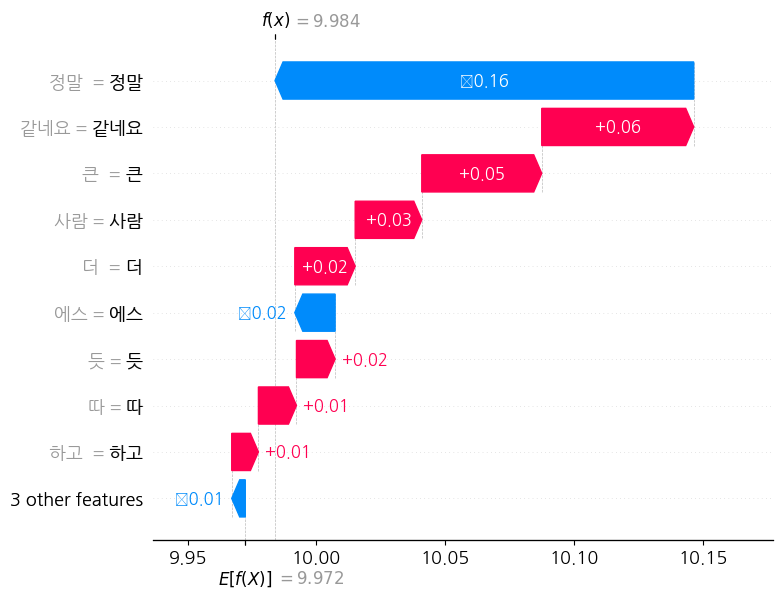

In [6]:
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=128) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)
# input_text = 'Ïñ¥Ï†ú ÎÑòÏõÉÍ≤ªÏñ¥Ïó¨ „Öã„ÖãÌäπÌûà ÎèÑÏ†ÑÍ≥®Îì†Î≤® „Öã„Öã„ÖãÏΩîÏöîÌÖå ÏòÅÏõêÌïòÎùº'
# input_text = 'ÌòêÏß§ÌëúÏãúÌï¥Îùº „ÖÖ„ÖÇ Í∏∞Î∂Ñ ÎçîÎüΩÎÖ∏'
input_text = 'ÏóêÏä§Îçî Ï†ïÎßê ÎßàÏùåÏù¥ Îî∞ÎìØÌïòÍ≥† ÌÅ∞ ÏÇ¨ÎûåÍ∞ôÎÑ§Ïöî'
shap_values = explainer([input_text])
print(shap_values.data)
shap.plots.waterfall(shap_values[0])
shap.initjs()
shap.plots.force(shap_values[0])

In [54]:
# define a prediction function
def f(x):
    tv = torch.tensor([tokenizer.encode(v, pad_to_max_length=True, max_length=128) for v in x]).cuda()
    outputs = model(tv)[0].detach().cpu().numpy()
    scores = (np.exp(outputs).T / np.exp(outputs).sum(-1)).T‚Ä∫
    val = sp.special.logit(scores[:,1]) # use one vs rest logit units
    return val

# build an explainer using a token masker
explainer = shap.Explainer(f, tokenizer)

# SHAPÏùÑ Ï†ÅÏö©Ìï† ÏûÖÎ†• Îç∞Ïù¥ÌÑ∞ ÏÑ†ÌÉù
num_samples = 10
sample_indices = range(num_samples)
samples = [test_data.iloc[i]["content"] for i in sample_indices]
shap_values = explainer(samples)

PartitionExplainer explainer: 11it [00:12,  3.23s/it]                        


In [55]:
samples

['Ïî®Î∞îÏïå..ÎÖ∏Î¨¥ÎÖ∏Î¨¥ Ïà†ÌîÑÎÖ∏... Ïò§Îäò Ï†ÄÎÖÅÏùÄ ÍΩÇÎì±Ïã¨Ïù¥Îã§„Ö†„Öú',
 'ÏïÑÎ¨¥Î¶¨ Î≤ïÏù¥ Î≠£Í∞ôÏïÑÎèÑ Î¨¥Ïä® ÏûêÍ≤©ÏúºÎ°ú Í∞úÏù∏Ïùò Ïã†ÏÉÅÏ†ïÎ≥¥Î•º Î∂àÌäπÏ†ï Îã§ÏàòÏóêÍ≤å Í≥µÍ∞úÌïòÎäîÏßÄ ÎèÑÏ†ÄÌûà Ïù¥Ìï¥Í∞Ä ÏïàÎêòÎÑ§Ïöî Î≤ïÏùÑ Î∞îÍæ∏Í∏∞ ÏúÑÌï¥ ÎÖ∏Î†•ÌïòÏÑ∏Ïöî Ï†ÄÎü∞ Îä•Î†•ÏúºÎ°ú Î∂àÎ≤ïÏ†ÅÏù∏ ÏùºÏùÑ Í≥µÍ≥µÏùò Ïù¥ÏùµÏúºÎ°ú Ìè¨Ïû•ÌïòÏßÄ ÎßàÏãúÍµ¨Ïöî',
 'Îã§ÏùåÎèÑ Îì§Ïñ¥ÏôÄÎùºÌïòÍ≥†...Îã§Î•∏ ÏùòÍ≤¨ÎÇ¥Îäî Ïú†ÌäúÎ≤Ñ Î™© ÏûêÎ•¥Í≥†....Ï∂îÏïÑÏ§åÎßà Í∫º Ïó¨Í∏∞Ï†ÄÍ∏∞ÏÑú ÏßÑÏà†ÎÇòÏò§Îãà...Î¨¥Ïä® Í∏∞Í∞ïÍ∞êÏ∞∞Ïù¥Îãà ÌïòÎ©∞ ÌòëÎ∞ïÎì§Ïñ¥Í∞ÄÍ≥†..... ÎåìÍ∏ÄÏóê Ï§ëÍµ≠ Îü¨ÏãúÏïÑ ÏöïÌïòÎäî ÏÇ¨ÎûåÎì§ Ïù¥Ï†ú ÏïÑÍ∞ÄÎ¶¨ Îã•Ï≥êÎùº. Ïö∞Î¶¨ÎÇòÎùºÎèÑ ÎòëÍ∞ôÏù¥ ÎêòÏóàÎã§.',
 'ÏßÄÏó∞Ïù¥ ÏñºÍµ¥ÏùÄ Îçî Î∞∞Ïö∞Í∞ôÎÑ§...',
 'Í∞úÎ≥Ñ Í≥µÎ¨¥Ïõê Î∑∞ÏõÖÎì§Ïùò Ìó∑ÏßÄÎûÑÏóê Î≠î Ï≤≠ÏôÄÎåÄÍπåÏßÄ Îì§Î®πÏù¥ÎäîÏßÄ... Îπ†ÎÅÑÎÑ§ ÎïåÎèÑ ÏàúÏãúÎ¶¨Í∞Ä Í∞úÎªòÏßìÌñàÏßÄ Ï≤≠ÏôÄÎåÄÎäî ÏïîÍ≤ÉÎèÑ ÏïäÌñàÏßÄ ÎßêÏûÖÎãàÎã§~',
 'ÎåÄÍπ®Î¨∏Ïù¥ Î¨∏Ïû¨Ïù∏ ÌòëÎ∞ïÎ≤îÏùÑ Ïâ¥ÎìúÏπòÎÑ§? Ïó≠Ïãú ÎåÄÍ∞ÄÎ¶¨Í∞Ä Î∂ïÏñ¥Ïù∏ÎìØ~',
 'ÎèàÏù¥Ï†ÑÎ∂ÄÎäî ÏïÑÎãàÎù

In [56]:
shap_values

.values =
array([array([-0.0006912 , -0.02056258, -0.00738998, -0.00899147, -0.02070763,
              -0.01650174, -0.01262137, -0.0272406 ,  0.00022729,  0.01073652,
               0.01114958, -0.00787449, -0.00735652,  0.02546394,  0.00584018,
               0.07309377,  0.04825014,  0.06315142, -0.04279453,  0.09432417,
              -0.16638273, -0.01280546, -0.01487118,  0.        ])            ,
       array([ 0.00048628, -0.01325956,  0.01677185, -0.03087014,  0.11836731,
              -0.01776606,  0.03170764,  0.0134694 ,  0.03915453,  0.00770688,
               0.03282768, -0.00660247,  0.04441947,  0.02368253, -0.01411718,
              -0.01203948,  0.00326617, -0.00174753, -0.00235134, -0.00068173,
              -0.00774246, -0.00866324, -0.00886802, -0.00822766, -0.00514325,
              -0.00810605, -0.03256185, -0.01758815,  0.00060222,  0.00060222,
              -0.00846432, -0.0231957 ,  0.00717807, -0.03364974, -0.08031845,
              -0.01493996, -0.02957606, -

In [50]:
samples[5]

'ÎåÄÍπ®Î¨∏Ïù¥ Î¨∏Ïû¨Ïù∏ ÌòëÎ∞ïÎ≤îÏùÑ Ïâ¥ÎìúÏπòÎÑ§? Ïó≠Ïãú ÎåÄÍ∞ÄÎ¶¨Í∞Ä Î∂ïÏñ¥Ïù∏ÎìØ~'

In [57]:
shap_values[5]

.values =
array([ 0.        , -0.33766222,  0.29422566, -0.22868499,  0.50718166,
        0.02840446,  0.05955225,  0.03414613, -0.21175283, -0.56736583,
       -0.06091577, -0.00749713, -0.41407418,  0.        ])

.base_values =
9.917678833007812

.data =
array(['', 'ÎåÄÍπ®Î¨∏Ïù¥ ', 'Î¨∏Ïû¨Ïù∏ ', 'ÌòëÎ∞ï', 'Î≤îÏùÑ ', 'Ïâ¥ÎìúÏπò', 'ÎÑ§', '? ', 'Ïó≠Ïãú ', 'ÎåÄÍ∞ÄÎ¶¨Í∞Ä ',
       'Î∂ïÏñ¥', 'Ïù∏ÎìØ', '~', ''], dtype='<U5')

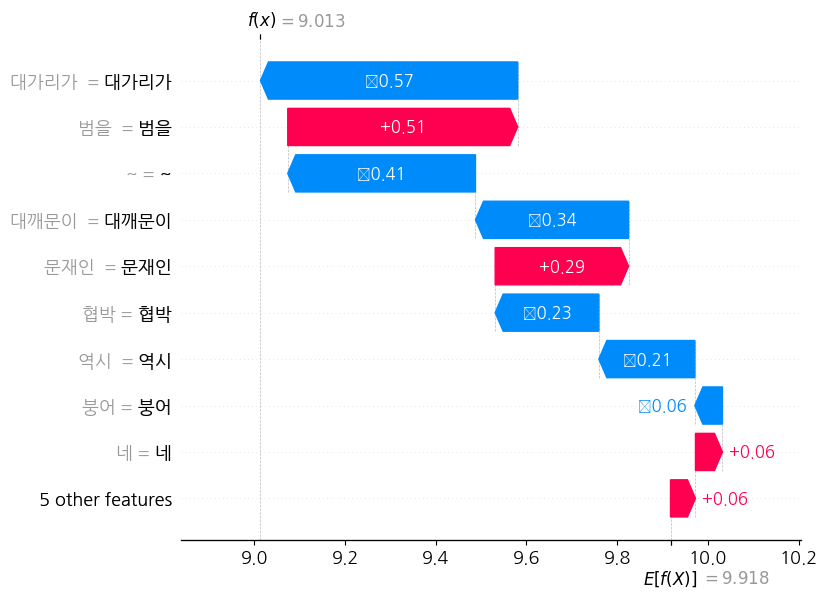

In [58]:
shap.plots.waterfall(shap_values[5])

In [32]:
# force plotÏùÑ ÌôúÏö©Ìïú Ï≤´ Î≤àÏß∏ ÏòàÏ∏° ÏÑ§Î™ÖÏùò ÏãúÍ∞ÅÌôî
shap.initjs()
shap.plots.force(shap_values[5])

In [7]:
sample = ['Ïö∞Î¶¨ÎÇòÎùºÎ•º ÏñºÎßàÎÇò Í∞úÎèºÏßÄÎ°ú Î≥¥ÎäîÍ±¥ÏßÄ Ïß±Íπ®ÎûëÏùÄ ÏÉÅÏ¢ÖÏùÑ ÌïòÏßÄ ÎßêÏïÑÏïºÌï¥']
shap_values = explainer(sample)
shap_values

.values =
array([[ 1.60932541e-06,  2.20121324e-01, -6.85901910e-01,
        -2.05193558e+00, -3.37285280e-01,  2.75001824e-02,
        -1.88155435e+00,  1.65527239e-01,  3.24404955e-01,
         5.44639617e-01,  5.86862922e-01, -3.06417793e-01,
         8.21542442e-01, -3.21865082e-06]])

.base_values =
array([9.91767883])

.data =
(array(['', 'Ïö∞Î¶¨ÎÇòÎùºÎ•º ', 'ÏñºÎßàÎÇò ', 'Í∞úÎèºÏßÄÎ°ú ', 'Î≥¥Îäî', 'Í±¥ÏßÄ ', 'Ïß±Íπ®', 'ÎûëÏùÄ ', 'ÏÉÅÏ¢Ö',
       'ÏùÑ ', 'ÌïòÏßÄ ', 'ÎßêÏïÑÏïº', 'Ìï¥', ''], dtype=object),)

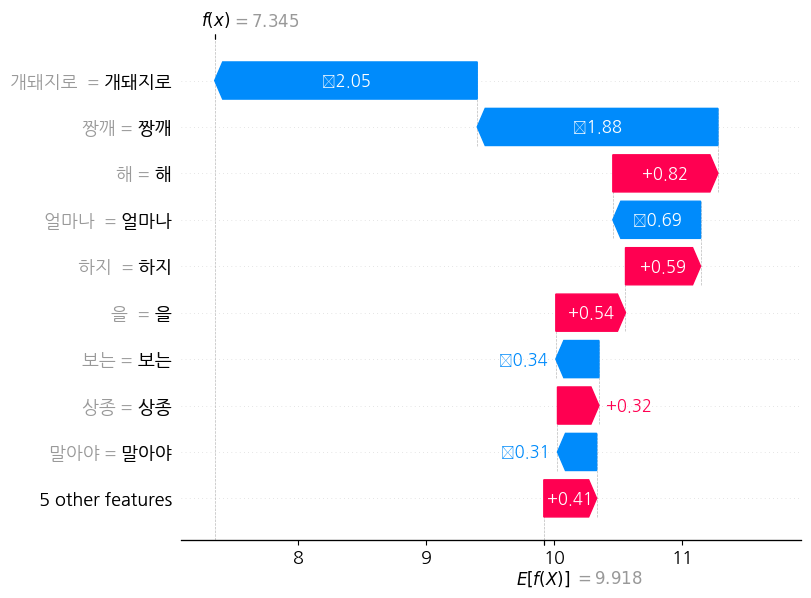

In [8]:
shap.plots.waterfall(shap_values[0])

In [9]:
# force plotÏùÑ ÌôúÏö©Ìïú Ï≤´ Î≤àÏß∏ ÏòàÏ∏° ÏÑ§Î™ÖÏùò ÏãúÍ∞ÅÌôî
shap.initjs()
shap.plots.force(shap_values[0])

## ÎßàÏä§ÌÇπ

In [36]:
samples[5]

'ÎåÄÍπ®Î¨∏Ïù¥ Î¨∏Ïû¨Ïù∏ ÌòëÎ∞ïÎ≤îÏùÑ Ïâ¥ÎìúÏπòÎÑ§? Ïó≠Ïãú ÎåÄÍ∞ÄÎ¶¨Í∞Ä Î∂ïÏñ¥Ïù∏ÎìØ~'

In [37]:
shap_values[5]

.values =
array([ 0.        , -0.33766222,  0.29422566, -0.22868499,  0.50718166,
        0.02840446,  0.05955225,  0.03414613, -0.21175283, -0.56736583,
       -0.06091577, -0.00749713, -0.41407418,  0.        ])

.base_values =
9.917678833007812

.data =
array(['', 'ÎåÄÍπ®Î¨∏Ïù¥ ', 'Î¨∏Ïû¨Ïù∏ ', 'ÌòëÎ∞ï', 'Î≤îÏùÑ ', 'Ïâ¥ÎìúÏπò', 'ÎÑ§', '? ', 'Ïó≠Ïãú ', 'ÎåÄÍ∞ÄÎ¶¨Í∞Ä ',
       'Î∂ïÏñ¥', 'Ïù∏ÎìØ', '~', ''], dtype='<U5')

In [39]:
shap_values[5].base_values

9.917678833007812

In [51]:
sum([i for i in shap_values[5].values if i < 0]) / len([i for i in shap_values[5].values if i < 0])

-0.2611361358846937

In [ ]:
mask_list = []

shap_values_zip = zip(shap_values[5].values, shap_values[5].data)
for shap_value, feature in shap_values_zip:
    if shap_value < -0.3: # threshold
        print(feature, shap_value)
        mask_list.append(feature.strip())

mask_list

ÎåÄÍπ®Î¨∏Ïù¥  -0.3376622200012207
ÎåÄÍ∞ÄÎ¶¨Í∞Ä  -0.567365825176239
~ -0.414074182510376


['ÎåÄÍπ®Î¨∏Ïù¥', 'ÎåÄÍ∞ÄÎ¶¨Í∞Ä', '~']

In [75]:
test_smaple = samples[5]
print(f"ÏõêÎ≥∏ Î¨∏Ïû• : {test_smaple}")

for mask in mask_list:
    # ÎßåÏïΩÏóê maskÍ∞Ä ÌäπÏàòÎ¨∏ÏûêÏù¥Î©¥ continue
    if not mask.isalnum():
        continue
    else:
        test_smaple = test_smaple.replace(mask, "[mask]")

print(f"ÎßàÏä§ÌÇπ Î¨∏Ïû• : {test_smaple}")

ÏõêÎ≥∏ Î¨∏Ïû• : ÎåÄÍπ®Î¨∏Ïù¥ Î¨∏Ïû¨Ïù∏ ÌòëÎ∞ïÎ≤îÏùÑ Ïâ¥ÎìúÏπòÎÑ§? Ïó≠Ïãú ÎåÄÍ∞ÄÎ¶¨Í∞Ä Î∂ïÏñ¥Ïù∏ÎìØ~
ÎßàÏä§ÌÇπ Î¨∏Ïû• : [mask] Î¨∏Ïû¨Ïù∏ ÌòëÎ∞ïÎ≤îÏùÑ Ïâ¥ÎìúÏπòÎÑ§? Ïó≠Ïãú [mask] Î∂ïÏñ¥Ïù∏ÎìØ~


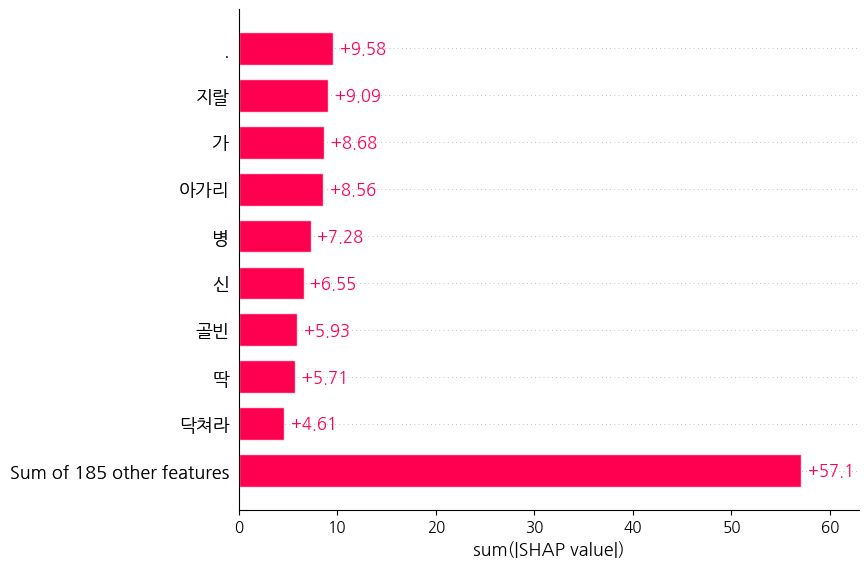

In [ ]:
shap.plots.bar(shap_values.abs.sum(0))

In [ ]:
# test data Ï†ÑÏ≤¥Ïóê ÎåÄÌïú shap value Í≥ÑÏÇ∞(ÏãúÍ∞Ñ Ïò§Îûò Í±∏Î¶º)
hap_values = explainer(test_data["content"].tolist())